In [335]:
import pandas as pd

We have created a 20% overlap for the samples to be labeled to assess the inter-rated agreement. Since annotator vary for each label duplicate pair, we can't use the sklearn's solution as it assumes that raters are the same in each case. Averaging the sklearn's  cohen_kappa_score along the pairs is not a viable solution since if you only have one data point per rater pair, the Cohen's kappa score calculation will result in a warning because it expects more variation in the data (or will return 0 if values are different).

We have calculated the Cohen's kappa for the dataset with the (wrong) assumption that there are only two annotators.
Further we improved the calculation with averaging the pairs, for that we have used this [solution](https://towardsdatascience.com/inter-annotator-agreement-2f46c6d37bf3) instead.

In [336]:
# https://towardsdatascience.com/inter-annotator-agreement-2f46c6d37bf3
def cohen_kappa(ann1, ann2):
    """Computes Cohen kappa for pair-wise annotators.
    :param ann1: annotations provided by first annotator
    :type ann1: list
    :param ann2: annotations provided by second annotator
    :type ann2: list
    :rtype: float
    :return: Cohen kappa statistic
    """
    count = 0
    for an1, an2 in zip(ann1, ann2):
        if an1 == an2:
            count += 1
    A = count / len(ann1)  # observed agreement A (Po)

    uniq = set(ann1 + ann2)
    E = 0  # expected agreement E (Pe)
    for item in uniq:
        cnt1 = ann1.count(item)
        cnt2 = ann2.count(item)
        count = ((cnt1 / len(ann1)) * (cnt2 / len(ann2)))
        E += count

    return round((A - E) / (1 - E), 4)

# 1st batch

## Loading and preprocessing the data

In [337]:
df_labels = pd.read_json('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/labels_ready.json')

In [338]:
def extract_emotion(info):
    for classification in info['classifications']:
        if classification['title'] == 'Чи присутня в тексті емоційна оцінка українців?':
            return classification['answer']['title']
    return 'ні, оцінка не присутня'

In [339]:
def extract_emotion(info):
    for classification in info['classifications']:
        if classification['title'] == 'Чи присутня в тексті емоційна оцінка українців?':
            return classification['answer']['title']
    return 'ні, оцінка не присутня'

In [340]:
def extract_dehumanization(info):
    for classification in info['classifications']:
        if classification['title'] == 'Чи прирівнюються українці до неістот, тварин чи людей, позбавлених людських рис (частково або повністю)?':
            return classification['answer']['title']
    return 'ні'

In [341]:
def extract_mention(info):
    for classification in info['classifications']:
        if classification['title'] == 'Чи згадуються в тексті українці або щось українське?':
            return classification['answer']['title']
    return None

In [342]:
df_labels["Dehumanization"] = df_labels.Label.apply(lambda x: extract_dehumanization(x))

In [343]:
df_labels["Emotion"] = df_labels.Label.apply(lambda x: extract_emotion(x))

In [344]:
df_labels["Mention"] = df_labels.Label.apply(lambda x: extract_mention(x))

In [345]:
#some Labels are empty, dropping those
df_labels[df_labels["Mention"].isna()]['Label'][369]

{'objects': [], 'classifications': [], 'relationships': []}

In [346]:
df_labels = df_labels[~df_labels["Mention"].isna()]

In [347]:
len(df_labels)

4250

In [348]:
df = df_labels[['Created By', 'Mention', 'Dehumanization', 'Emotion', 'External ID']]

In [349]:
value_counts = df['External ID'].value_counts()
unique_rows = df[df['External ID'].isin(value_counts[value_counts == 1].index)]
df.drop(unique_rows.index, inplace=True)
df.reset_index(inplace=True, drop=True)

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_52700/350336781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(unique_rows.index, inplace=True)


In [350]:
df = df.sort_values(by='External ID')
df.reset_index(inplace=True, drop=True)

# First attempt to calculate with the assumption that annotators are same

In [351]:
df['Rater'] = ['Rater1' if i % 2 == 0 else 'Rater2' for i in range(len(df))]

In [232]:
from sklearn.metrics import cohen_kappa_score

# define a function to calculate Cohen's kappa for a given column
def calculate_kappa(column_name):
    rater1_labels = df[column_name].loc[df['Rater'] == 'Rater1'].tolist()
    rater2_labels = df[column_name].loc[df['Rater'] == 'Rater2'].tolist()
    kappa = cohen_kappa_score(rater1_labels, rater2_labels)
    return kappa

In [233]:
# calculate Cohen's kappa for the 'Dehumanization' column
dehumanization_kappa = calculate_kappa('Dehumanization')
print("Cohen's kappa for Dehumanization: {:.2f}".format(dehumanization_kappa))

# repeat the above for the 'Emotion' and 'Mention' columns
emotion_kappa = calculate_kappa('Emotion')
print("Cohen's kappa for Emotion: {:.2f}".format(emotion_kappa))

mention_kappa = calculate_kappa('Mention')
print("Cohen's kappa for Mention: {:.2f}".format(mention_kappa))

Cohen's kappa for Dehumanization: 0.69
Cohen's kappa for Emotion: 0.70
Cohen's kappa for Mention: 0.92


# Correct calculation under the real conditions of different annotators

In [352]:
def calculate_cohens_kappa(df, col_name):
    # creating the data for question
    df_column = df[['External ID', 'Created By', col_name]]

    # identifying the overlapping samples and raters who labeled them
    overlapping_samples = df_column.groupby('External ID').filter(lambda x: len(x) > 1)
    unique_sample_ids = overlapping_samples['External ID'].unique()
    rater_pairs = []
    for sample_id in unique_sample_ids:
        raters = overlapping_samples[overlapping_samples['External ID'] == sample_id]['Created By'].tolist()
        rater_pairs.append(raters)

    # averaging the kappa scores for pairs
    kappa_scores = []
    for sample_id, rater_pair in zip(unique_sample_ids, rater_pairs):
        sample_data = overlapping_samples[overlapping_samples['External ID'] == sample_id]
        rater1_labels = sample_data[sample_data['Created By'] == rater_pair[0]][col_name].tolist()[0]
        rater2_labels = sample_data[sample_data['Created By'] == rater_pair[1]][col_name].tolist()[0]
        kappa = cohen_kappa(rater1_labels, rater2_labels)
        kappa_scores.append(kappa)
    mean_kappa_score = sum(kappa_scores) / len(kappa_scores)

    return mean_kappa_score

In [353]:
calculate_cohens_kappa(df, 'Dehumanization')

0.8462920454545458

In [354]:
calculate_cohens_kappa(df, 'Mention')

0.968306818181818

In [355]:
calculate_cohens_kappa(df, 'Emotion')

0.8560982954545455

In [356]:
def split_samples_based_on_agreement(df, col_name, positive_class):
    df_column = df[['External ID', 'Created By', col_name]]

    overlapping_samples = df_column.groupby('External ID').filter(lambda x: len(x) > 1)
    unique_sample_ids = overlapping_samples['External ID'].unique()

    agreement_samples = pd.DataFrame(columns = df_column.columns)
    disagreement_samples = pd.DataFrame(columns = df_column.columns)

    for sample_id in unique_sample_ids:
        sample_data = overlapping_samples[overlapping_samples['External ID'] == sample_id]
        labels = sample_data[col_name].tolist()

        if labels.count(positive_class) == 2:
            agreement_samples = pd.concat([agreement_samples, sample_data])
        elif labels.count(positive_class) == 1:
            disagreement_samples = pd.concat([disagreement_samples, sample_data])

    return agreement_samples, disagreement_samples

In [357]:
agg_samples, disagr_samples = split_samples_based_on_agreement(df, "Dehumanization", 'так')

In [359]:
len(agg_samples)/(len(agg_samples)+len(disagr_samples))

0.7470588235294118

# Labels export - 1st batch

In [183]:
import os
import pandas as pd

directory_path = "/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/dataset_shuffled"
file_list = []
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):
        with open(os.path.join(directory_path, filename), "r") as file:
            file_content = file.read()
        file_list.append({"text": file_content, "file_name": filename})

df_datarows = pd.DataFrame(file_list)

In [184]:
df_datarows.rename(columns={'file_name':'External ID'}, inplace=True)
df_datarows

,text,External ID
0,"Как известно, свинья везде грязь найдет, и укр...",row_1281.txt
1,"Тогда как многие украинцы, наоборот, слепо вер...",row_2950.txt
2,"О таком щедром и мирном соседе, как Россия, мо...",row_3496.txt
3,🇺🇦❌Денацификация по-винницки Тивривский сельс...,row_2788.txt
4,Укронацисты объявили войну Пушкину.,row_2944.txt
...,...,...
3638,"«Я вас, бл@дей, на этот корабль три года собир...",row_2791.txt
3639,Награжден орденом Мужества за отвагу и самоотв...,row_474.txt
3640,🇷🇺В районе населенного пункта Часов Яр уничтож...,row_2949.txt
3641,Участники конкурса американской армии на замен...,row_1298.txt


In [185]:
df_datarows[df_datarows['External ID'] == 'row_3210.txt']

,text,External ID
2016,"""Бандеровцы на Украине сегодня взяли все худше...",row_3210.txt


In [186]:
df_final=df_labels[['Emotion','Dehumanization', 'Mention', 'External ID', 'Created By']]

In [187]:
df_final

,Emotion,Dehumanization,Mention,External ID,Created By
0,"ні, оцінка не присутня",ні,ні,row_3642.txt,kateryna.burovova@ucu.edu.ua
1,"ні, оцінка не присутня",ні,ні,row_3641.txt,kateryna.burovova@ucu.edu.ua
2,"так, присутня негативна",так,так,row_3640.txt,kateryna.burovova@ucu.edu.ua
3,"так, присутня негативна",так,так,row_3639.txt,kateryna.burovova@ucu.edu.ua
4,"так, присутня негативна",так,так,row_3637.txt,snizannabotvin@gmail.com
...,...,...,...,...,...
4279,"так, присутня негативна",так,так,row_9.txt,eugene.1martynyuk@gmail.com
4280,"ні, оцінка не присутня",ні,ні,row_666.txt,eugene.1martynyuk@gmail.com
4281,"так, присутня негативна",так,так,row_21.txt,eugene.1martynyuk@gmail.com
4282,"так, присутня негативна",так,так,row_660.txt,eugene.1martynyuk@gmail.com


In [188]:
df_final["Emotion"].unique()

array(['ні, оцінка не присутня', 'так, присутня негативна',
       'не можу визначитись з правильною відповіддю',
       'так, присутня позитивна'], dtype=object)

In [189]:
df_final["Mention"].unique()


array(['ні', 'так', 'не можу визначитись із відповіддю'], dtype=object)

In [190]:
df_merged = pd.merge(df_final, df_datarows, on='External ID', how='left')

In [191]:
#bs check
df_merged[df_merged['Mention']=='ні']['Dehumanization'].unique()


array(['ні'], dtype=object)

In [192]:
#bs check
df_merged[df_merged['Mention']=='ні']['Emotion'].unique()

array(['ні, оцінка не присутня'], dtype=object)

In [193]:
df_merged

,Emotion,Dehumanization,Mention,External ID,Created By,text
0,"ні, оцінка не присутня",ні,ні,row_3642.txt,kateryna.burovova@ucu.edu.ua,"❗️Один из протестующих погиб, заявили в МВД Бе..."
1,"ні, оцінка не присутня",ні,ні,row_3641.txt,kateryna.burovova@ucu.edu.ua,Предлагаем немного отвлечься и поиграть в игру...
2,"так, присутня негативна",так,так,row_3640.txt,kateryna.burovova@ucu.edu.ua,⚡️🇺🇦🇷🇺В Запорожской области ВСУ скапливают вой...
3,"так, присутня негативна",так,так,row_3639.txt,kateryna.burovova@ucu.edu.ua,"Украина открыла глаза Далмерсу, и он начал рас..."
4,"так, присутня негативна",так,так,row_3637.txt,snizannabotvin@gmail.com,Корчинский - дешёвая проститутка неоконовского...
...,...,...,...,...,...,...
4245,"так, присутня негативна",так,так,row_9.txt,eugene.1martynyuk@gmail.com,🇺🇦12 000 укронацистов готовят атаку на Мелитоп...
4246,"ні, оцінка не присутня",ні,ні,row_666.txt,eugene.1martynyuk@gmail.com,Наш фильм неожиданно для нас самих попал в топ...
4247,"так, присутня негативна",так,так,row_21.txt,eugene.1martynyuk@gmail.com,P.S. Укрорейх не спим. @rosich_rus
4248,"так, присутня негативна",так,так,row_660.txt,eugene.1martynyuk@gmail.com,"Наша с вами задача не скатываться в режим ""зра..."


At this stage we should choose whose labels should remain in the final dataset for those samples labeled by 2 labelers.

We have investigated a random portion of disagreements manually as only manual investigation can provide insights into potential biases and/or misunderstanding of guidelines.
We have also considered the annotator expertise and background that we were informed of.

In [194]:
authors = df_labels['Created By'].unique().tolist()
rating = [1, 4, 7, 6, 8, 2, 5, 3, 9]

In [195]:
data = {'Created By': authors, 'rating': rating}
df_rating = pd.DataFrame(data)

In [196]:
df_combined = df_merged.merge(df_rating, on='Created By')

In [197]:
df_combined = df_combined.sort_values(['External ID', 'rating'], ascending=True)

In [198]:
df_combined

,Emotion,Dehumanization,Mention,External ID,Created By,text,rating
1219,"так, присутня негативна",так,так,row_0.txt,snizannabotvin@gmail.com,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",4
1218,"ні, оцінка не присутня",ні,ні,row_1.txt,snizannabotvin@gmail.com,Литературный критик Галина Юзефович о новом ро...,4
1591,"так, присутня негативна",так,так,row_10.txt,snizannabotvin@gmail.com,Почему на базах неонацистов стоят языческие ис...,4
1198,"так, присутня негативна",так,так,row_100.txt,snizannabotvin@gmail.com,Группа добровольцев-медиков из Чеченской Респу...,4
3247,"ні, оцінка не присутня",ні,так,row_1000.txt,tutovadesign@gmail.com,"ВСУшники, переходите на сторону добра, у нас т...",5
...,...,...,...,...,...,...,...
3612,"так, присутня негативна",ні,так,row_996.txt,tutovadesign@gmail.com,И понеслась мазепинщино-петлюровщино-бандеровщ...,5
4121,"так, присутня негативна",ні,так,row_997.txt,yevhen.marchenko91@gmail.com,Наш соратник по русскому движению Алексей Сели...,3
4120,"ні, оцінка не присутня",так,так,row_998.txt,yevhen.marchenko91@gmail.com,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,3
3249,"так, присутня негативна",так,так,row_998.txt,tutovadesign@gmail.com,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,5


In [199]:
df_cleaned = df_combined.drop_duplicates(subset='External ID', keep='first')

In [200]:
df_cleaned

,Emotion,Dehumanization,Mention,External ID,Created By,text,rating
1219,"так, присутня негативна",так,так,row_0.txt,snizannabotvin@gmail.com,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",4
1218,"ні, оцінка не присутня",ні,ні,row_1.txt,snizannabotvin@gmail.com,Литературный критик Галина Юзефович о новом ро...,4
1591,"так, присутня негативна",так,так,row_10.txt,snizannabotvin@gmail.com,Почему на базах неонацистов стоят языческие ис...,4
1198,"так, присутня негативна",так,так,row_100.txt,snizannabotvin@gmail.com,Группа добровольцев-медиков из Чеченской Респу...,4
3247,"ні, оцінка не присутня",ні,так,row_1000.txt,tutovadesign@gmail.com,"ВСУшники, переходите на сторону добра, у нас т...",5
...,...,...,...,...,...,...,...
3613,"ні, оцінка не присутня",ні,так,row_995.txt,tutovadesign@gmail.com,Утренний брифинг Минобороны России: ▪️ россий...,5
3612,"так, присутня негативна",ні,так,row_996.txt,tutovadesign@gmail.com,И понеслась мазепинщино-петлюровщино-бандеровщ...,5
4121,"так, присутня негативна",ні,так,row_997.txt,yevhen.marchenko91@gmail.com,Наш соратник по русскому движению Алексей Сели...,3
4120,"ні, оцінка не присутня",так,так,row_998.txt,yevhen.marchenko91@gmail.com,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,3


Double-checking since it's crucial for our task

In [261]:
value_counts = df_combined['External ID'].value_counts()
unique_rows = df_combined[df_combined['External ID'].isin(value_counts[value_counts == 1].index)]
df_bs_check = df_combined.drop(unique_rows.index)

In [262]:
df_bs_check.sort_values(['External ID'])

,Emotion,Dehumanization,Mention,External ID,Created By,text,rating
4119,"так, присутня негативна",так,так,row_1005.txt,yevhen.marchenko91@gmail.com,"Оно провалилось, но укровояки хвалились тем, ч...",3
3242,"так, присутня негативна",ні,так,row_1005.txt,tutovadesign@gmail.com,"Оно провалилось, но укровояки хвалились тем, ч...",5
4118,"так, присутня негативна",так,так,row_1006.txt,yevhen.marchenko91@gmail.com,Западный мем о степени правдивости пропаганды ...,3
3241,"так, присутня негативна",так,так,row_1006.txt,tutovadesign@gmail.com,Западный мем о степени правдивости пропаганды ...,5
4117,"так, присутня негативна",так,так,row_1008.txt,yevhen.marchenko91@gmail.com,Война до последнего украинца – это вовсе не вы...,3
...,...,...,...,...,...,...,...
2384,"так, присутня негативна",так,так,row_98.txt,nazariy.melnychuk9@gmail.com,Благодаря такому единству можно уверенно гаран...,7
126,"ні, оцінка не присутня",ні,ні,row_984.txt,kateryna.burovova@ucu.edu.ua,Этапы Китайской компартии по пути к мировой ге...,1
3673,"ні, оцінка не присутня",ні,ні,row_984.txt,tutovadesign@gmail.com,Этапы Китайской компартии по пути к мировой ге...,5
4120,"ні, оцінка не присутня",так,так,row_998.txt,yevhen.marchenko91@gmail.com,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,3


In [263]:
df_cleaned[df_cleaned['External ID']=='row_1128.txt']

,Emotion,Dehumanization,Mention,External ID,Created By,text,rating
507,"так, присутня негативна",так,так,row_1128.txt,snizannabotvin@gmail.com,По виртуальным планам укрорейха они уже взяли ...,4


In [264]:
df_cleaned.to_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/final_labels.csv')

In [205]:
df_cleaned.Mention.unique()

array(['так', 'ні', 'не можу визначитись із відповіддю'], dtype=object)

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

color_dict_emotion = {"так, присутня негативна": "red", "ні, оцінка не присутня": "blue", "не можу визначитись з правильною відповіддю": "yellow", "так, присутня позитивна": "blue"}
color_dict_dehumanization = {"так": "red", "ні": "blue", "не можу визначитись з правильною відповіддю": "yellow"}
color_dict_mention = {"так": "red", "ні": "blue", "не можу визначитись із відповіддю": "yellow"}

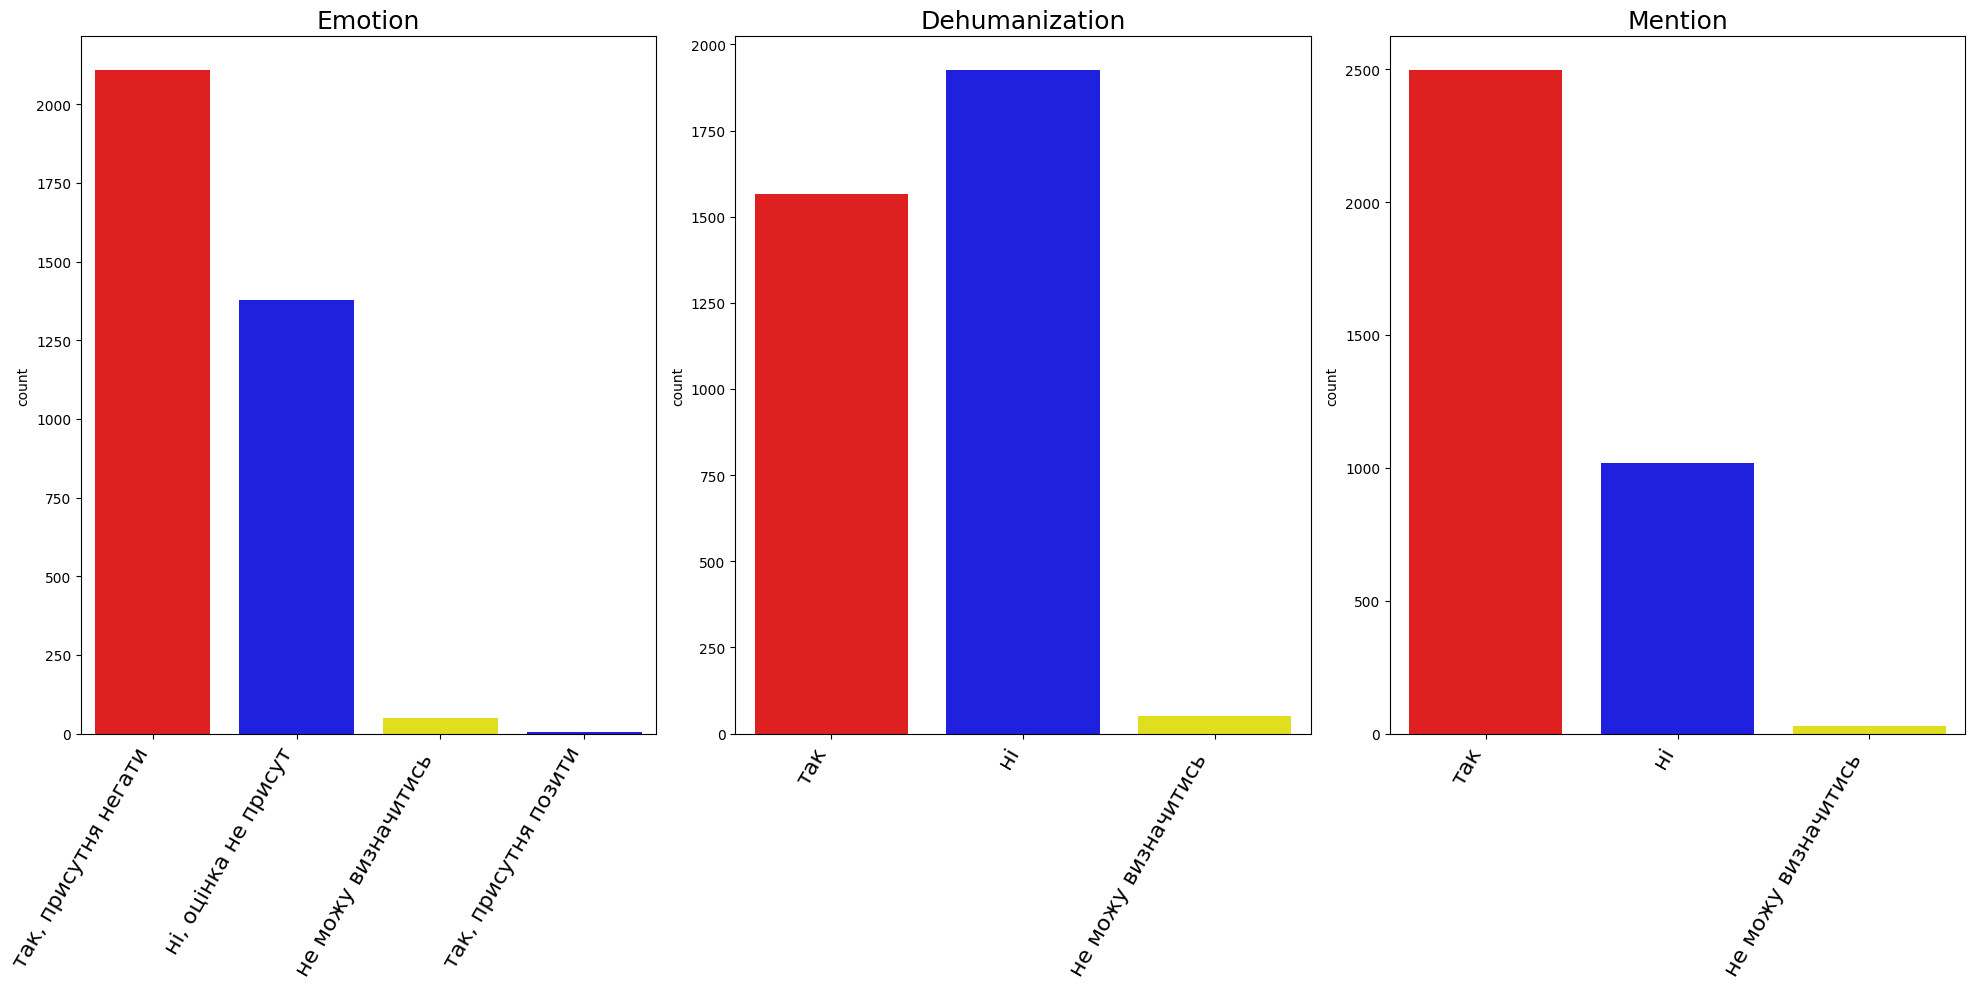

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

sns.countplot(x="Emotion", data=df_cleaned, palette=color_dict_emotion, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=60, ha='right', fontsize=16)  # Adjust fontsize here
ax[0].set_xlabel('')
ax[0].set_title('Emotion', fontsize=18)  # Adjust title fontsize here

sns.countplot(x="Dehumanization", data=df_cleaned, palette=color_dict_dehumanization, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=60, ha='right', fontsize=16)  # Adjust fontsize here
ax[1].set_xlabel('')
ax[1].set_title('Dehumanization', fontsize=18)  # Adjust title fontsize here

sns.countplot(x="Mention", data=df_cleaned, palette=color_dict_mention, ax=ax[2])
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=60, ha='right', fontsize=16)  # Adjust fontsize here
ax[2].set_xlabel('')
ax[2].set_title('Mention', fontsize=18)  # Adjust title fontsize here

for a in ax:
    a.set_xticklabels([label.get_text()[:20] for label in a.get_xticklabels()], rotation=60)

plt.tight_layout()
plt.show()


# 2nd batch

In [259]:
import pandas as pd
import json

def read_ndjson_to_df(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

In [260]:
file_path = '/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/new_batch/export_labelsAR1_2ndbatch.ndjson'
df_labels_2batch = read_ndjson_to_df(file_path)

In [261]:
def extract_id(row):
    return row['id']

df_labels_2batch['ID'] = df_labels_2batch['data_row'].apply(extract_id)

In [262]:
ids_list_2nd_batch = df_labels_2batch['ID'].tolist()

Now we export all the labels including the last batch to have duplicated labels for consensus rows.

In [2]:
import json
with open('config_annotation.json') as f:
    config = json.load(f)
API_KEY = config['API_KEY']

import labelbox
LB_API_KEY = API_KEY
lb = labelbox.Client(api_key=LB_API_KEY)
project = lb.get_project('cleh63iav1py2070b93oo9o0l')
export_url = project.export_labels()

In [3]:
import requests

response = requests.get(export_url)

if response.status_code == 200:
    with open('exported_labels.json', 'wb') as f:
        f.write(response.content)

In [265]:
df_export_all_labels = pd.read_json('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/new_batch/exported_labels.json')

In [266]:
df_export_2nd_batch = df_export_all_labels[df_export_all_labels['DataRow ID'].isin(ids_list_2nd_batch)].copy()

In [267]:
df_export_2nd_batch["Dehumanization"] = df_export_2nd_batch.Label.apply(lambda x: extract_dehumanization(x))
df_export_2nd_batch["Emotion"] = df_export_2nd_batch.Label.apply(lambda x: extract_emotion(x))
df_export_2nd_batch["Mention"] = df_export_2nd_batch.Label.apply(lambda x: extract_mention(x))

In [268]:
calculate_cohens_kappa(df_export_2nd_batch, 'Dehumanization')

0.9731238938053097

In [269]:
calculate_cohens_kappa(df_export_2nd_batch, 'Emotion')

0.8621389380530975

In [270]:
calculate_cohens_kappa(df_export_2nd_batch, 'Mention')

0.9203539823008849

In [271]:
df_final_2nd_batch =df_export_2nd_batch[['Emotion','Dehumanization', 'Mention', 'External ID', 'Created By']]

# Labels export - 2nd batch

In [272]:
import os
import pandas as pd

directory_path = "/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/new_batch/new_batch_shuffled"
file_list = []
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):
        with open(os.path.join(directory_path, filename), "r") as file:
            file_content = file.read()
        file_list.append({"text": file_content, "file_name": filename})

df_datarows = pd.DataFrame(file_list)

In [273]:
df_datarows.rename(columns={'file_name':'External ID'}, inplace=True)

In [274]:
df_merged = pd.merge(df_final_2nd_batch, df_datarows, on='External ID', how='left')

In [275]:
authors = df_merged['Created By'].unique().tolist()
rating = [1, 2]

In [276]:
data = {'Created By': authors, 'rating': rating}
df_rating = pd.DataFrame(data)

In [277]:
df_combined = df_merged.merge(df_rating, on='Created By')
df_combined = df_combined.sort_values(['External ID', 'rating'], ascending=True)


In [278]:
df_cleaned = df_combined.drop_duplicates(subset='External ID', keep='first')

In [279]:
df_cleaned.Dehumanization.unique()

array(['ні', 'так', 'не можу визначитись з правильною відповіддю'],
      dtype=object)

In [280]:
df_cleaned.Mention.unique()

array(['так', 'ні'], dtype=object)

In [281]:
df_cleaned.Emotion.unique()

array(['ні, оцінка не присутня', 'так, присутня негативна',
       'так, присутня позитивна',
       'не можу визначитись з правильною відповіддю'], dtype=object)

In [242]:
df_cleaned.to_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/final_labels_2nd_batch.csv')

In [282]:
df_cleaned

,Emotion,Dehumanization,Mention,External ID,Created By,text,rating
677,"ні, оцінка не присутня",ні,так,row_0.txt,tutovadesign@gmail.com,❗️Украинские вооруженные формирования выпустил...,2
117,"ні, оцінка не присутня",ні,так,row_1.txt,kateryna.burovova@ucu.edu.ua,Медведев о результатах выборов президента на У...,1
667,"ні, оцінка не присутня",ні,так,row_10.txt,tutovadesign@gmail.com,🇺🇦🇷🇺Вооруженные силы Украины не способны к кон...,2
577,"ні, оцінка не присутня",ні,так,row_100.txt,tutovadesign@gmail.com,"Есть информация, что пленный «Махач» из «Азова...",2
99,"ні, оцінка не присутня",ні,так,row_101.txt,kateryna.burovova@ucu.edu.ua,На территории Херсонской области вскрыта и пре...,1
...,...,...,...,...,...,...,...
102,"ні, оцінка не присутня",ні,так,row_95.txt,kateryna.burovova@ucu.edu.ua,Киев не собирается нападать на Россию — глава ...,1
101,"так, присутня негативна",ні,так,row_96.txt,kateryna.burovova@ucu.edu.ua,"Президент Зеленский утверждает, что ‘Украина н...",1
100,"ні, оцінка не присутня",ні,так,row_97.txt,kateryna.burovova@ucu.edu.ua,🇷🇺Авиация поддерживает наступление наших войск...,1
579,"ні, оцінка не присутня",ні,ні,row_98.txt,tutovadesign@gmail.com,С выплатой компенсаций пострадавшим от теракта...,2


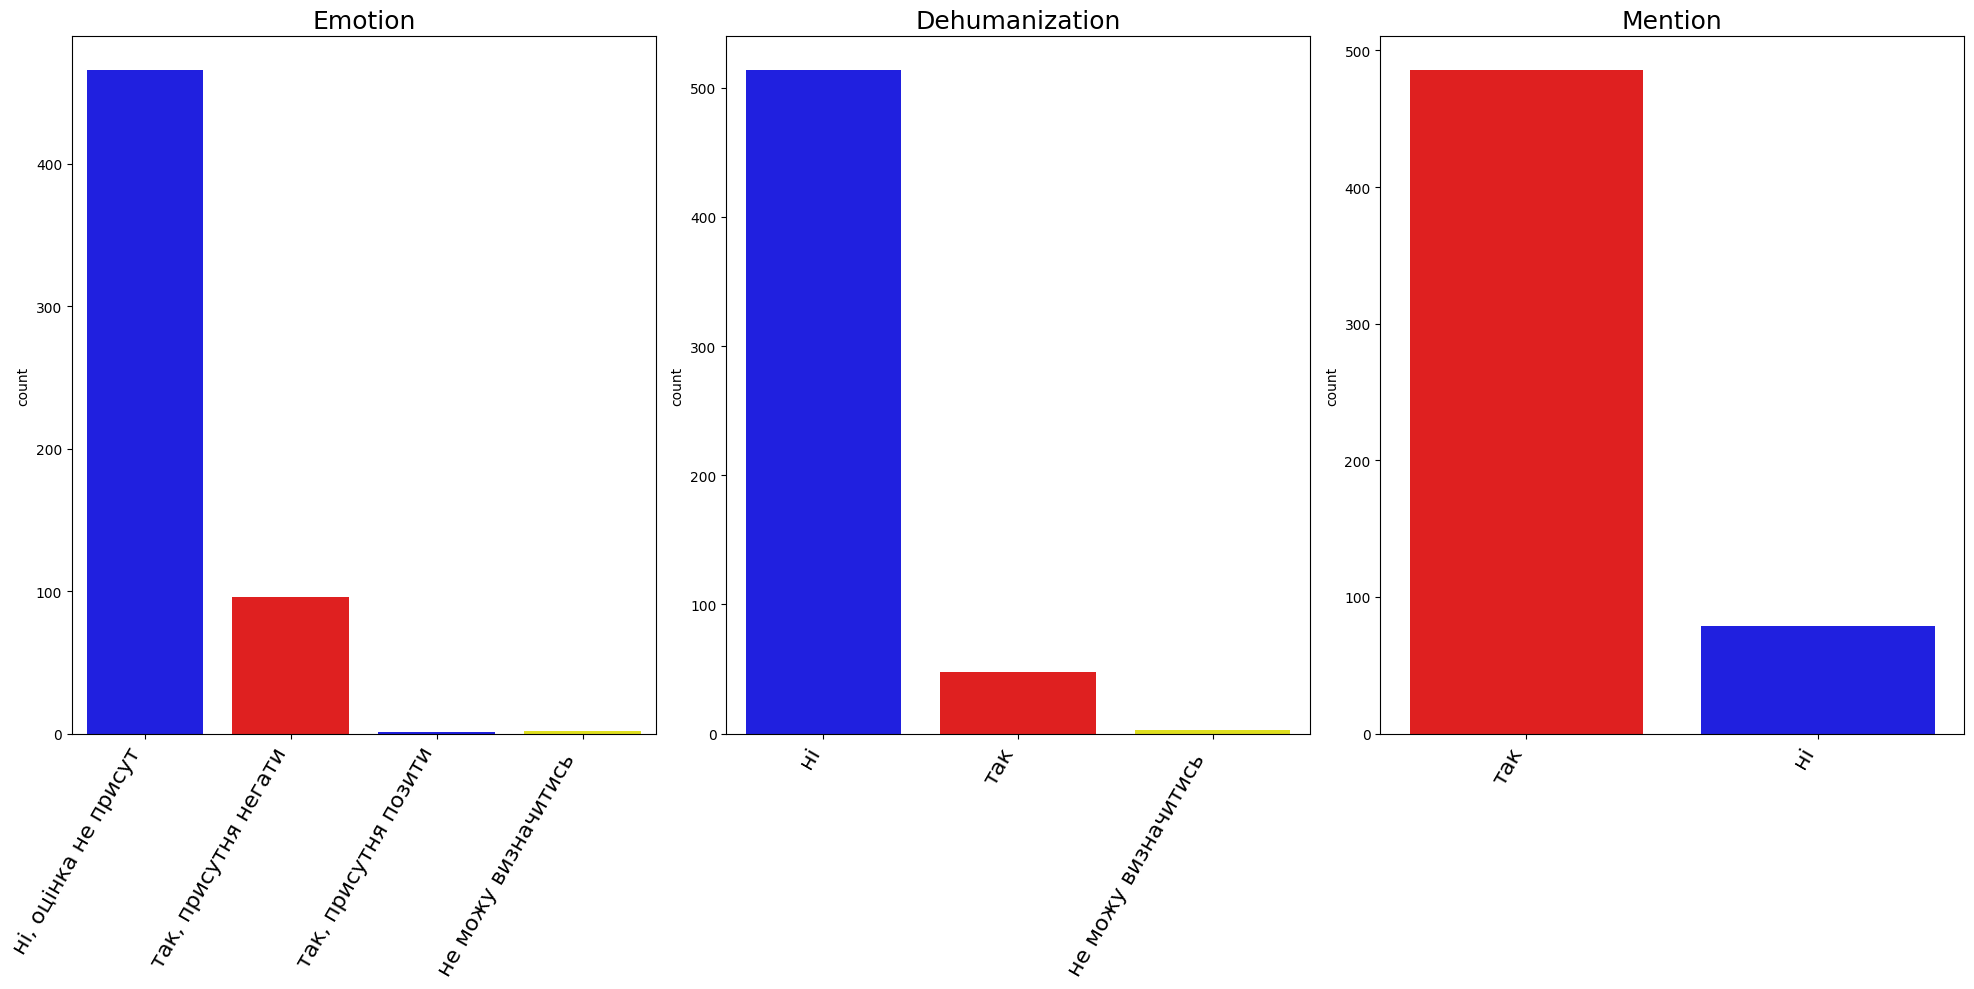

In [244]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

sns.countplot(x="Emotion", data=df_cleaned, palette=color_dict_emotion, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=60, ha='right', fontsize=16)  # Adjust fontsize here
ax[0].set_xlabel('')
ax[0].set_title('Emotion', fontsize=18)  # Adjust title fontsize here

sns.countplot(x="Dehumanization", data=df_cleaned, palette=color_dict_dehumanization, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=60, ha='right', fontsize=16)  # Adjust fontsize here
ax[1].set_xlabel('')
ax[1].set_title('Dehumanization', fontsize=18)  # Adjust title fontsize here

sns.countplot(x="Mention", data=df_cleaned, palette=color_dict_mention, ax=ax[2])
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=60, ha='right', fontsize=16)  # Adjust fontsize here
ax[2].set_xlabel('')
ax[2].set_title('Mention', fontsize=18)  # Adjust title fontsize here

for a in ax:
    a.set_xticklabels([label.get_text()[:20] for label in a.get_xticklabels()], rotation=60)

plt.tight_layout()
plt.show()


In [245]:
df_cleaned.Dehumanization.value_counts()

ні                                             514
так                                             48
не можу визначитись з правильною відповіддю      3
Name: Dehumanization, dtype: int64

Since positive class of Dehumanization is rare, the overall agreement statistic might is calculated on the negative class mostly. Let's calculate the agreement for the positive class only.

In [322]:
agreement_samples, disagreement_samples = split_samples_based_on_agreement(df_final_2nd_batch, 'Dehumanization', 'так')

In [333]:
len(agreement_samples)/(len(agreement_samples)+len(disagreement_samples))

0.8

So for positive class annotators agreed on 80% samples, which is less than overall agreement but still without bound of substantial agreement.